In [1]:
from openvino.inference_engine import IENetwork, IEPlugin
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
plugin = IEPlugin(device="CPU")
plugin.add_cpu_extension(r"C:\Program Files (x86)\IntelSWTools\openvino\deployment_tools\inference_engine\bin\intel64\Release\cpu_extension_avx2.dll")

model_xml = "models/person-detection-retail-0013.xml"
model_bin = "models/person-detection-retail-0013.bin"

In [3]:
def load_model(plugin, model, weights):
    """
    Load OpenVino IR Models

    Input:
    Plugin = Hardware Accelerator
    Model = model_xml file 
    Weights = model_bin file
    
    Output:
    execution network (exec_net)
    """
    #  Read in Graph file (IR) to create network
    net = IENetwork(model, weights) 
    # Load the Network using Plugin Device
    exec_net = plugin.load(network=net)
    return net, exec_net

def preprocessing(n, c, h, w):
    """
    Image Preprocessing steps, to match image 
    with Input Neural nets
    
    N=1, Channel=3, Height=62, Width=62
    """
    blob = cv.resize(image, (w, h)) # Resize width & height
    blob = blob.transpose((2, 0, 1)) # Change data layout from HWC to CHW
    blob = blob.reshape((n, c, h, w))
    return blob

## Person Detection

In [4]:
net, exec_net = load_model(plugin, model_xml,model_bin)

input_net = 'data'
output_net = 'detection_out'

n,c,h,w = net.inputs[input_net].shape

In [5]:
net.outputs

{'detection_out': <openvino.inference_engine.ie_api.OutputInfo at 0x18fd5adc4e0>}

(902, 1601, 3)


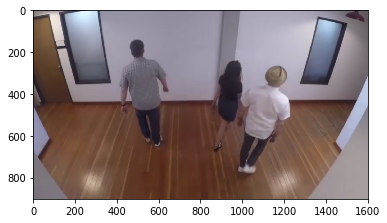

In [6]:
image = cv.imread('test_image.png')
plt.imshow(image[...,::-1]);
print(image.shape)

In [7]:
blob = preprocessing(n,c,h,w)
req_handle = exec_net.start_async(0, {input_net:blob})

In [8]:
status = req_handle.wait()
res = req_handle.outputs[output_net]
res.shape

(1, 1, 200, 7)

In [9]:
res[0][0][0:3]

array([[0.        , 1.        , 0.998926  , 0.59963655, 0.3004798 ,
        0.7743883 , 0.9180858 ],
       [0.        , 1.        , 0.99802905, 0.25844464, 0.1570496 ,
        0.40431592, 0.94416374],
       [0.        , 1.        , 0.99061686, 0.53394294, 0.2651455 ,
        0.63580334, 0.8010309 ]], dtype=float32)

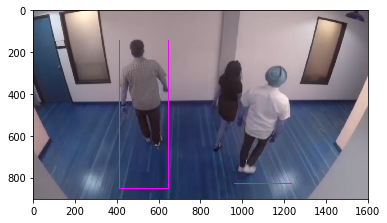

In [10]:
for detection in res[0][0]:
    confidence = detection[2]
    xmin = int(detection[3] * image.shape[1])
    ymin = int(detection[4] * image.shape[0])
    xmax = int(detection[5] * image.shape[1])
    ymax = int(detection[6] * image.shape[0])
    if confidence > 0.9:
        cv.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,255))
        

plt.imshow(image);

In [11]:
cv.imwrite('out.png', image)

True